In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from google.colab import drive
from statsmodels.graphics.tsaplots import plot_acf
import math

In [2]:
#### IMPORTANT THINGS TO WE FIND
#### The skewness being all over the place month-wise is very intereting to see. Wonder why?
#### Should really be including some factors to account for structural breaks in the date. ****
#### As expected most firms are dying pretty quickly, which is why is important to avoid the surviorship bias in our data
#### Skewed - Realized Vol, MaxRet, IdioVol3F, High52, Firm Age, Beta(positive skew), lnP, TK
#### Extremevals - EP, Realizedvol, MOM6m, MOM12, MaxRet, IdioVol3F, Beta
#### Talking about correlation with Ret -- Realized Vol, IdioVol3F, FirmAge, and TK seem significant
#### Only TK and Return skew seems to have a visible relation with returns.
#### Also keep in mind these are last-months returns so there is a need of another \\
#### exploration with the future returns (hence the shape of high52 and maxRet)
#### Another thing that pops up is the FirmAge vs Ret distribution. Worth looking into!

In [3]:
# Set seaborn dark theme
sns.set_theme(style="darkgrid")
d_bg = sns.axes_style()["axes.facecolor"]
# Use a lighter color palette
colors = sns.color_palette("pastel")
plt.rcParams['figure.facecolor'] = '#3b3b3b'
plt.rcParams['text.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'

In [4]:
colors

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.7254901960784313, 0.9490196078431372, 0.9411764705882353)]

In [5]:
### To start with let's inspect the returns data

In [6]:
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/Quantitative Investment Portfolio/Data/'

Mounted at /content/drive


In [7]:
data = pd.read_parquet(data_dir + 'processed_returns.parquet')

In [8]:
data.head(1)

,date,permno,yyyymm,ret,lnP,lnsize,hsiccd,RF,excess_ret,lret,1m.lret,6m.lret,12m.lret
0,1990-01-01,10001,199001,-1.8519,2.296315,9.225832,4925.0,0.57,-2.4219,-2.45171,-1.206145,-0.595824,-5.234258


In [9]:
data.index = pd.to_datetime(data.yyyymm, format='%Y%m')
data.index.name = 'ddate'

In [10]:
def figsA(dfr):
  fig1(dfr)
  fig2(dfr)
  fig3(dfr)
  fig4(dfr)

In [11]:
def fig1(data):
    plt.figure(figsize=(15, 3))
    plt.hexbin(x=data.index.map(pd.Timestamp.toordinal), y=data, cmap='mako',gridsize=30)
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.title('Returns Over Time')
    plt.grid(True)
    plt.show()

In [12]:
def fig2(data):
    plt.figure(figsize=(15, 3))
    sns.histplot(data, kde=True, color=colors[4])  # Use a color from the palette
    plt.title('Distribution of Returns')
    plt.xlabel('Return')
    plt.ylabel('Frequency')
    plt.show()

In [13]:
def fig3(data):
    r = 0.05
    mask1 = abs(data) > r
    df = data[mask1]
    plt.figure(figsize=(15, 3))
    sns.histplot(df, kde=True, color=colors[4])  # Use a color from the palette
    plt.title('Distribution of Returns')
    plt.xlabel('Return')
    plt.ylabel('Frequency')
    plt.show()

In [14]:
def fig4(data):
    time_stats = data.groupby(data.index).agg(['mean', 'std', 'skew', 'count'])
    yearly_data = time_stats.groupby(time_stats.index.year).mean()
    yearly_data.index = pd.to_datetime(yearly_data.index, format='%Y') + pd.DateOffset(months=5)
    # Create the figure and axes with shared x-axes
    fig, axes = plt.subplots(2, 2, figsize=(15, 5), sharex='col')

    # Plot cross-sectional statistics
    titles = ['Cross-sectional Returns','Cross-sectional Volatility','Cross-sectional Skewness','Number of Stocks']
    for i,j,col,t in zip([0,0,1,1],[0,1,0,1],time_stats.columns,titles):
        ax = axes[i, j]
        sns.scatterplot(ax=ax, x=time_stats.index, y=time_stats[col], label=col, color=colors[3*i+2*j])
        sns.lineplot(ax=ax, x=yearly_data.index, y=yearly_data[col], label="Yearly", color='red')
        if(i==1):
          ax.xaxis.tick_top()
          ax.xaxis.set_label_position('bottom')
        if(j==1):
          ax.yaxis.set_label_position('right')
          ax.yaxis.tick_right()
        ax.set_xlabel(t)
        ax.legend()

    # Adjust layout
    plt.tight_layout()
    plt.show()

In [15]:
def figsB(dfs):
    cols = ['mean', 'std', 'count']
    comp_stats = dfs.groupby(dfs.permno).agg(cols)
    comp_stats.columns = cols

    fig,axes = plt.subplots(3,1,figsize=(15, 9))
    axes = axes.flatten()

    for i, col in enumerate(cols):
        sns.histplot(comp_stats[col], kde=True, ax=axes[i], color=colors[5])
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

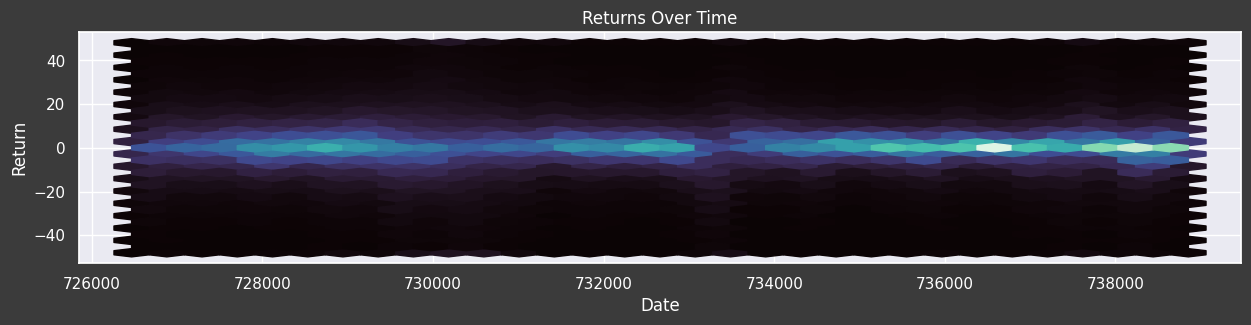

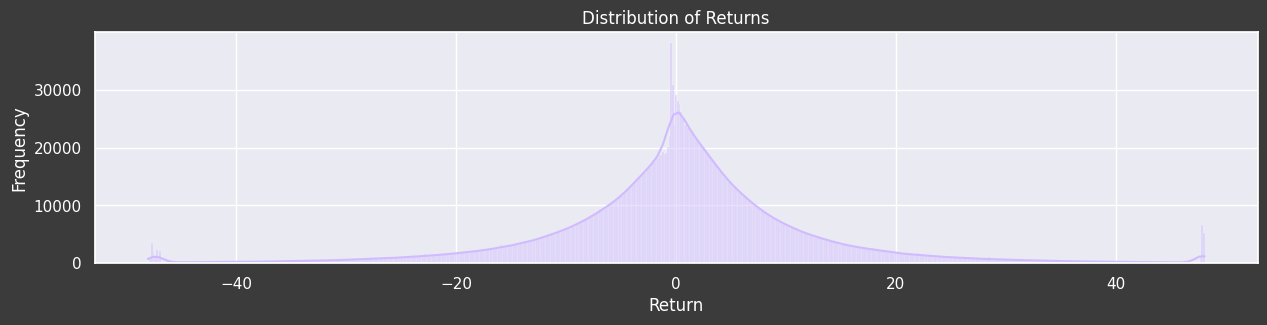

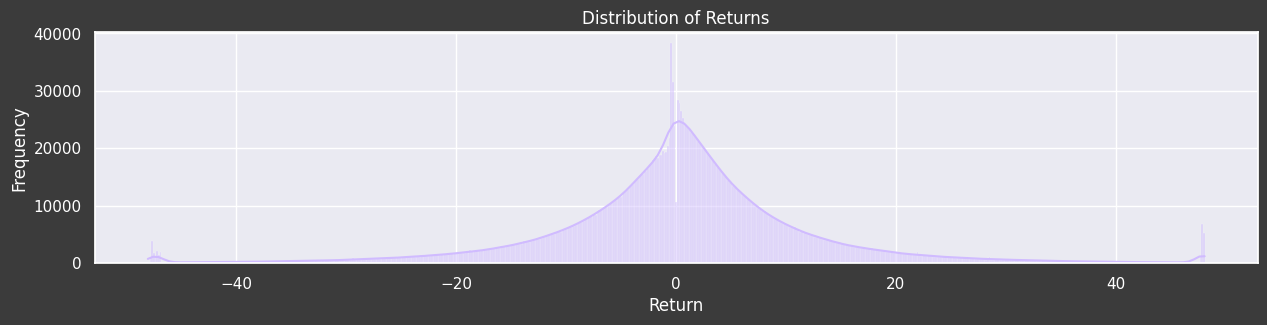

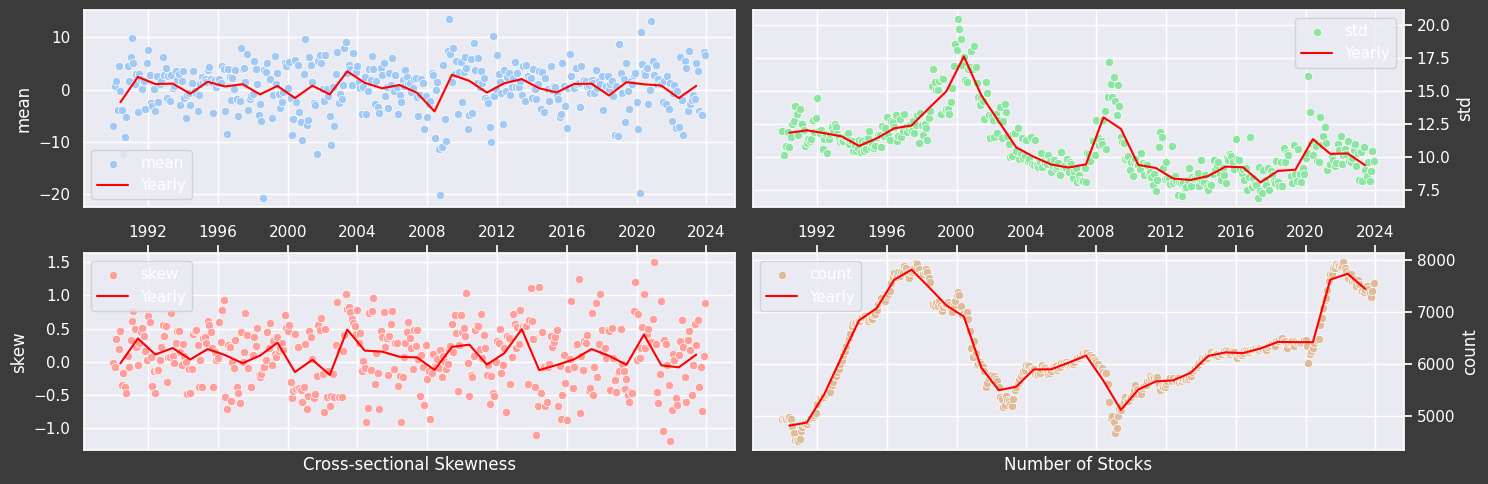

In [25]:
df = data['lret']
figsA(df)

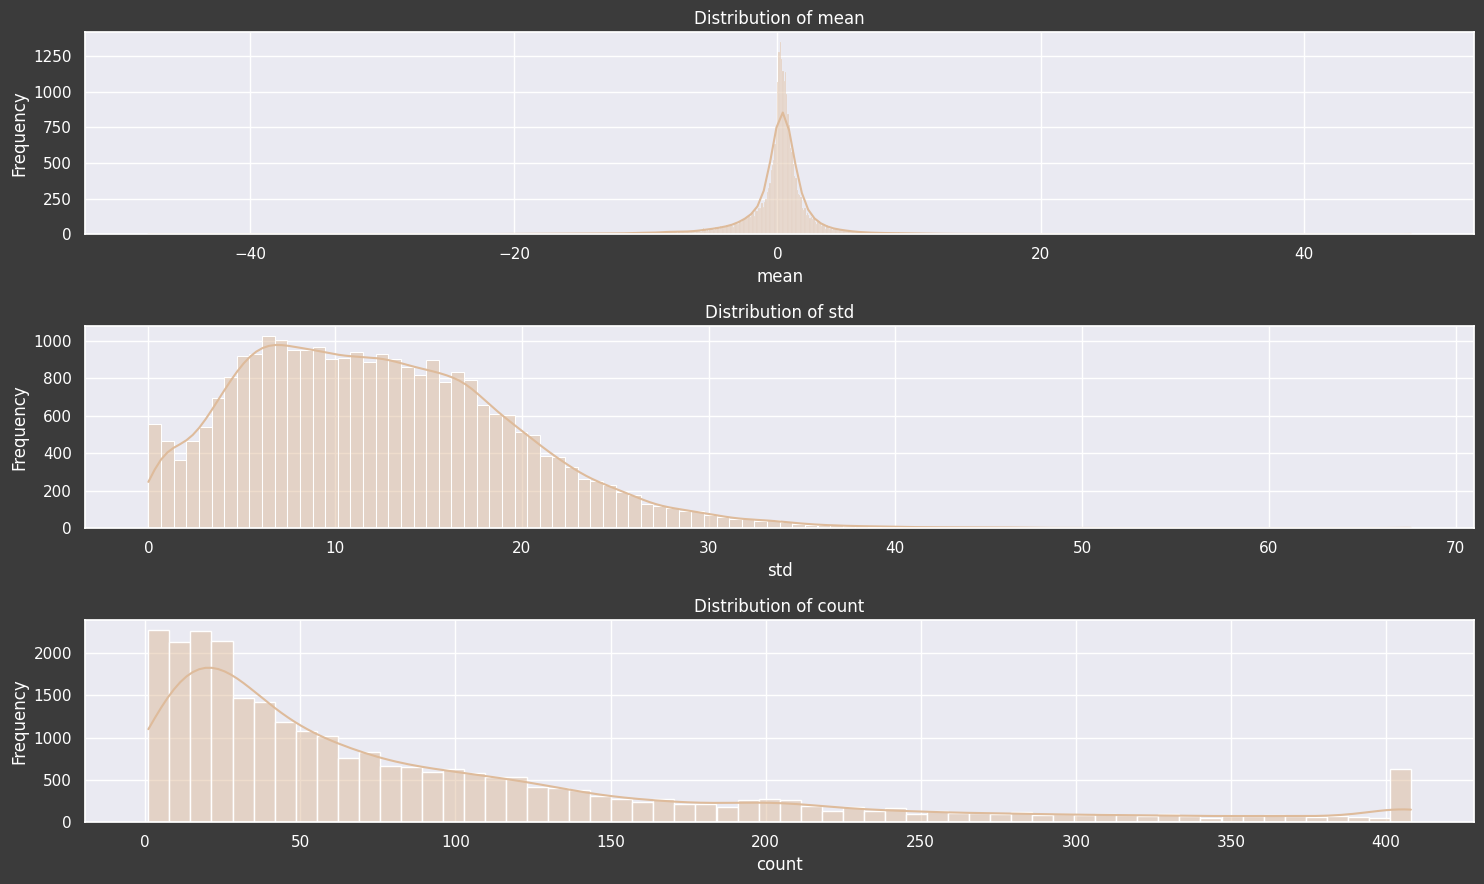

In [26]:
df = data[['lret','permno']]
figsB(df)

In [16]:
### The main insight from this is just that returns seems to be more volatile and
### extreme near 2000, 2008 and 2020 all years having a significant events. Other
### that the general trend seems to be towards shrinkage

In [17]:
#### Note that 0 is highest frquency which makes sense. Let's how the distribution of non-zero returns is like

In [18]:
### Hmmm returns is normally histributed with a negative skew and a local peak near 0- area

In [19]:
#### The skewness being all over the place month-wise is very intereting to see. Wonder why?
#### Buut other than skewness is consistent with the fact that it happends in cases of worldly events
#### Volatility has similar structural breaks but is consistent unlike skewness and there seems to be a downward trend.
#### Given that we recently had a spike - It should be going down again in the near future.
#### Wonder if there is a way to capitalize this through the model. **
#### Should really be including some factors to account for structural breaks in the date. ****
#### Now the returns themselves don't really tell you much. Seem pretty Consitent with what you would expect.
#### They now range from -10% to 10% but even that is neutralized in the yearly frame.
#### Could try these things after accounting for seasonality which isn't too difficult but not a tangent I am questioning rightnow.

In [20]:
### Moving forward - Let's look into returns classified by Company and then Industry.

In [21]:
## Noting to note except the negative skew

In [22]:
#### As exoected most firms are dying pretty quickly, which is it is important to avoid the surviorship bias in our data

In [23]:
#### Most firms have minimal skew but it exists and hence should be factored in while building the model.

In [24]:
#### The Standard Deviation seems to pretty high for some firms. Interesting to note.

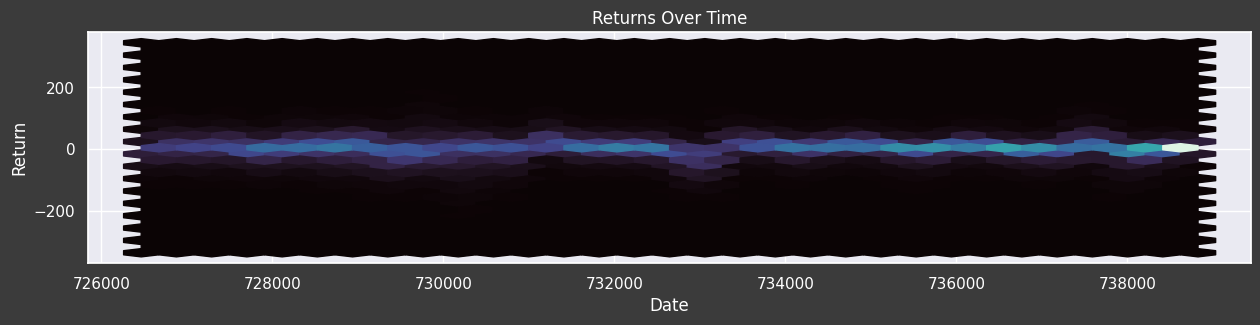

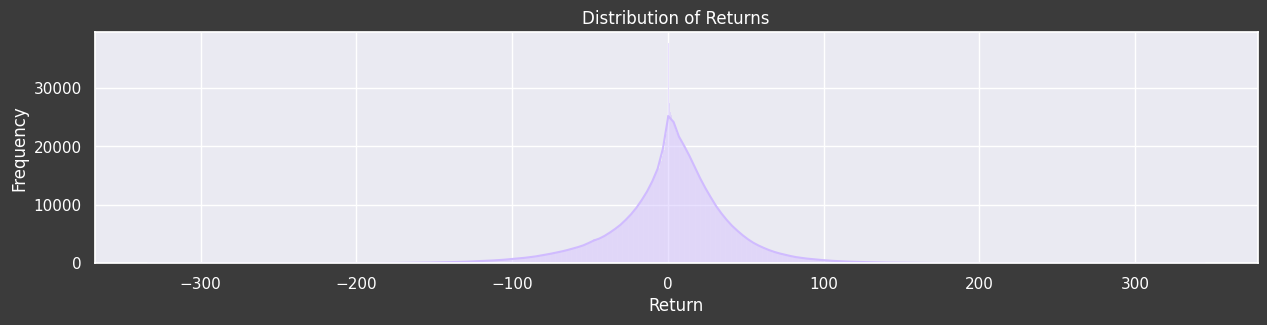

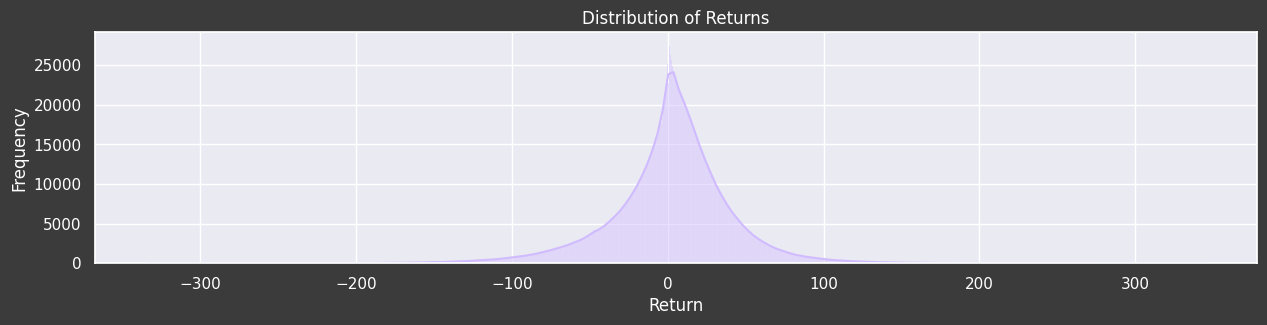

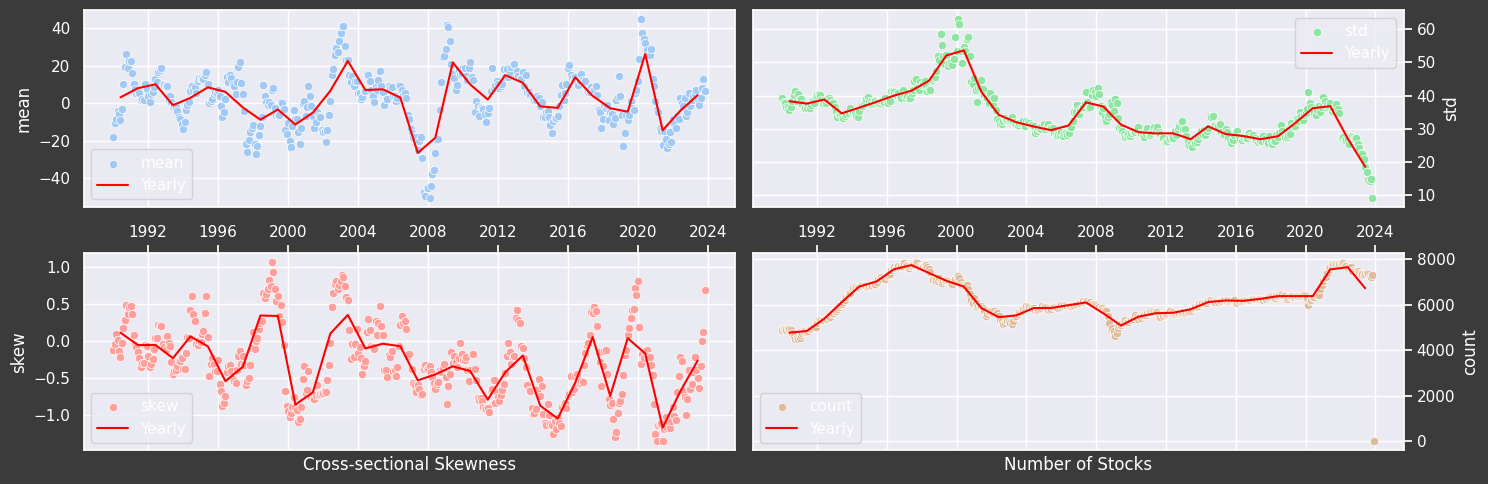

In [27]:
df = data['12m.lret']
figsA(df)

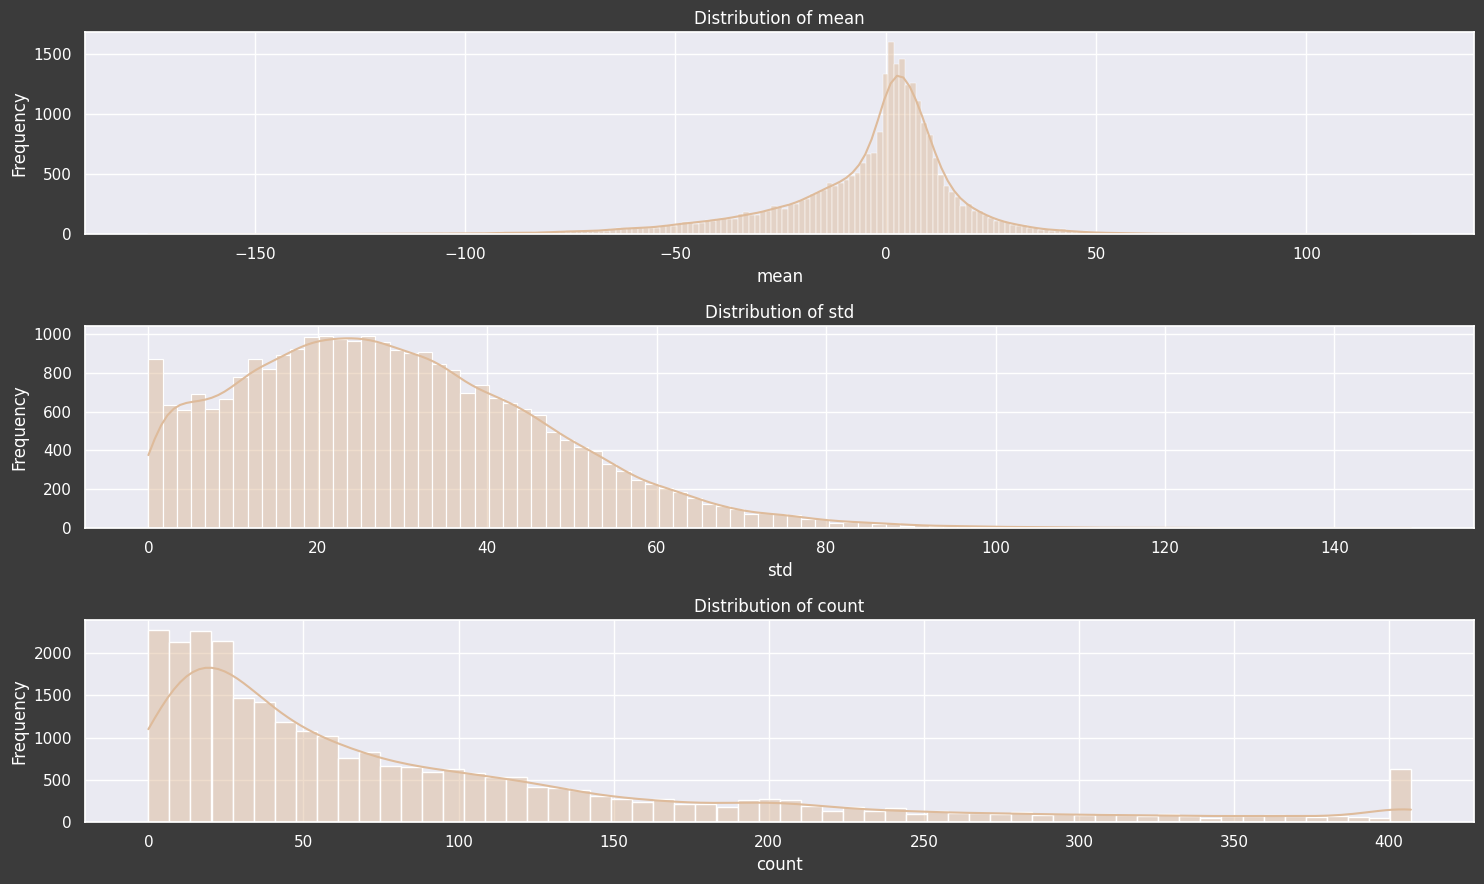

In [28]:
df = data[['12m.lret','permno']]
figsB(df)

## Auto-correlation

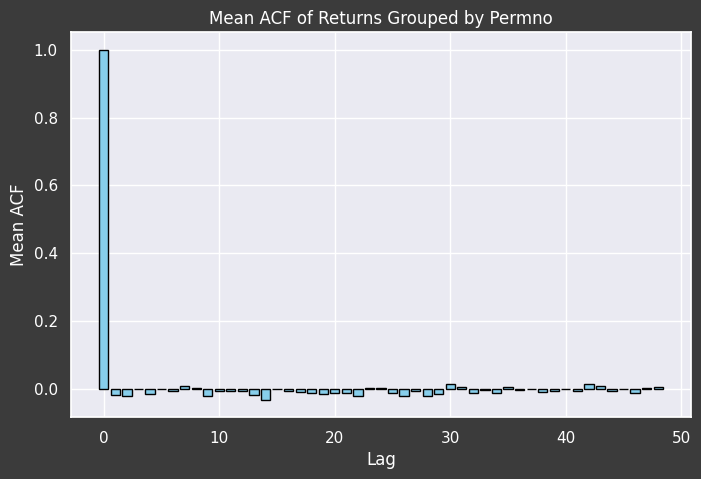

In [32]:
from statsmodels.tsa.stattools import acf

# Group by 'permno' and sort each group by date
grouped = data.sort_values(['permno', 'yyyymm']).groupby('permno')['ret']

acf_results = grouped.apply(lambda x: acf(x.dropna(), nlags=48) if len(x) > 48 else None)
acf_results = pd.DataFrame([x for x in acf_results if x is not None])
mean_acf = acf_results.mean()

# Plot the mean ACF
plt.figure(figsize=(8, 5))
plt.bar(range(len(mean_acf)), mean_acf, color='skyblue', edgecolor='black')
plt.title("Mean ACF of Returns Grouped by Permno")
plt.xlabel("Lag")
plt.ylabel("Mean ACF")
plt.show()

In [33]:
#### Well it's negligible but worth checking out. Anyways seem like there is not much autocorrelation in returns in general.

<Axes: >

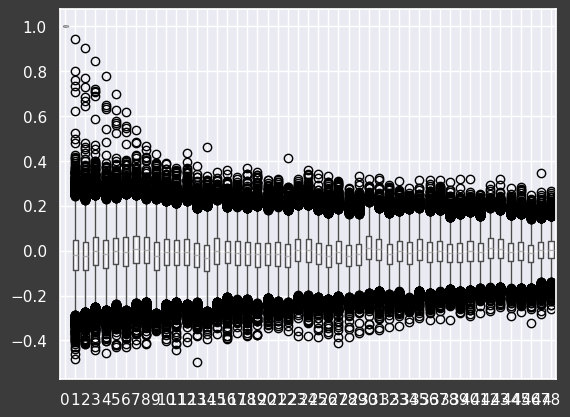

In [34]:
acf_results.boxplot()

In [35]:
#### AH HAH! 0.2 is significant. Seems like a very small percentile of stocks have it though. So moving on